In [ ]:
import os
import pickle
import torch

import torch.nn.functional as F
import pandas as pd
import numpy as np
import lovely_tensors as lt

from collections import Counter, defaultdict
from collections import defaultdict
from tqdm import tqdm
from typing import Union, Set, List
from GTM_WAE.preprocessing import SequenceDataset
from GTM_WAE.model import GTM_WAE
from IPython.display import Image

In [ ]:
lt.monkey_patch()

## 1. Preparation stage

### Set Random Seed For Reproducibility

In [ ]:
np.random.seed(seed=42)
import random
random.seed(42)

### Functions

In [ ]:
def read_nodes_nd_coordinates(wphi_mat_file):
    """
    Reads a .csv file containing node coordinates and returns them as a NumPy array.

    Parameters:
    wphi_mat_file (str): The path to the .mat file containing the node coordinates. 
                         The file is expected to have no header, with one row to skip 
                         at the beginning and one row to skip at the end.

    Returns:
    numpy.ndarray: A NumPy array containing the node coordinates.
    """
    df_nodes_coords = pd.read_csv(wphi_mat_file, skiprows=1, skipfooter=1, header=None, engine='python')
    nodes_coords = df_nodes_coords.to_numpy()
    return nodes_coords

In [ ]:
# Function to decode sequence indices to peptide sequences
def retrieve_sequence(seq_indices, itos):
    """
    Decodes a sequence of indices to a peptide sequence using a given index-to-symbol mapping.

    Parameters:
    seq_indices (list of int): A list of indices representing the peptide sequence.
    itos (dict): A dictionary mapping indices to their corresponding symbols (amino acids).

    Returns:
    str: The decoded peptide sequence as a string.
    """
    decoded_pep = ""
    for idx in seq_indices:
        if idx == 0:
            break
        else:
            decoded_pep += itos[idx]
    return decoded_pep

### Reference activity landscape

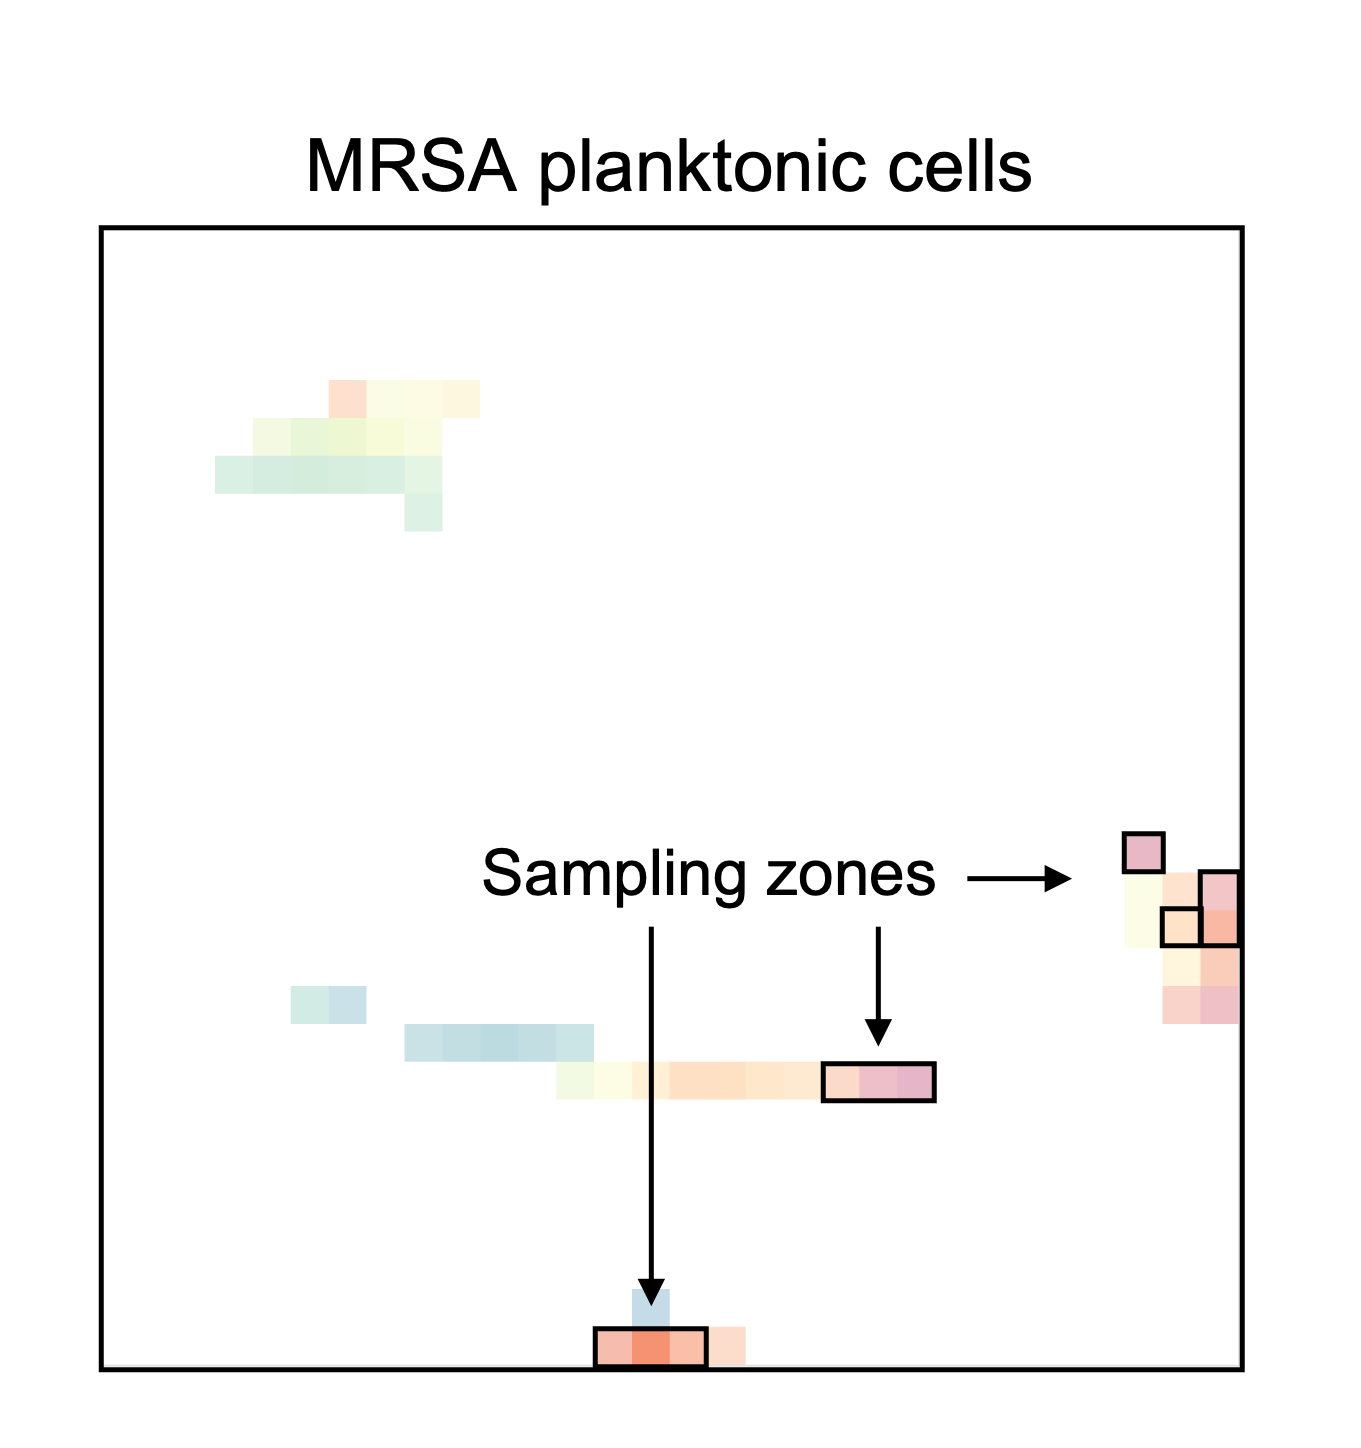

In [27]:
img_path = '../../images/activity_landscape_plank.png'
display(Image(filename=img_path, width=300, height=200))

### File Paths (files are available at https://huggingface.co/datasets/karinapikalyova/peptides/tree/main)

In [ ]:
# GTM nodes' coordinates
wphi_mat_file_resampled = "/path/main_map_resampledWPhi.mat"
# Model's weights
nn_weights = "/path/old_model_rec_rate=0.98.ckpt"
# Vocabulary defined by the tarining set peptides
vocabulary_path = "/path/allDBs_short_peps_wo_dupl_vocab.pkl"

### Load Pre-trained Model

In [ ]:
# Load the pre-trained neural network model
model = GTM_WAE.load_from_checkpoint(nn_weights)  
model = model.eval()

### Load vocabulary

In [ ]:
with open(vocabulary_path, "rb") as inp:
    vocabulary = pickle.load(inp)

## 2. Generate Sequences from Nodes

In [ ]:
# Define nodes to sample from
nodes_to_sample_from = [653, 623, 593, 827, 888, 420, 889, 859, 450, 480]
# Set scale (std) parameter 
scale = 0.8

In [ ]:
# Read node coordinates as a numpy array
nodes_coords = read_nodes_nd_coordinates(wphi_mat_file_resampled)

In [ ]:
# Iterate over nodes and generate sequences
results_nodes = set()
for node_id in nodes_to_sample_from:
    for i in tqdm(range(30000)):
        sampled_res = model.sample(model.sample_from_node(nodes_coords[node_id - 1], scale)).numpy()
        sampled_res = tuple(a for a in sampled_res.astype(int).tolist() if a)
        if sampled_res not in known_pep:
            results_nodes.add(sampled_res)

In [ ]:
# Check the number of unique sequences generated
len(results_nodes)

## 3. Convert Sequence Indices to Amino Acid Strings

In [ ]:
# Create a dictionary to save sequences and their sources
to_save = {"sequence": [], "generated_from": []}
for seqinds in list(results_nodes):
    to_save["sequence"].append(retrieve_sequence(seqinds, vocabulary.itos))
    to_save["generated_from"].append("node")

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(to_save)

## 4. Save the generated peptides

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv("/path/generated.csv", index=False)

---